# PART III
## Kernel perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from helpers import *
from collections import Counter
from itertools import combinations

np.random.seed(123)  # give a fixed seed for reproducability
from sklearn.model_selection import train_test_split

In [2]:
#loading data
zipcombo = np.loadtxt('zipcombo.dat')
zipcombo_qater = zipcombo[:len(zipcombo)//4]
training_data = np.loadtxt('dtrain123.dat')
test_data = np.loadtxt('dtest123.dat')
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)

#some training data is continuous, need to make sure everything is either -1 or 1

(257,)


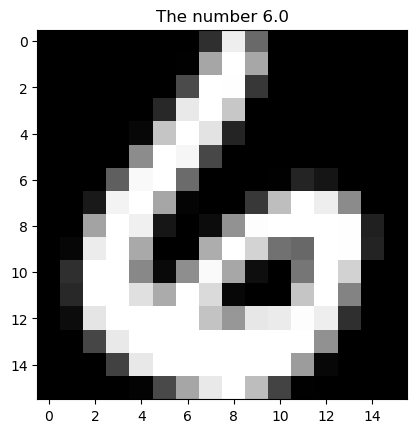

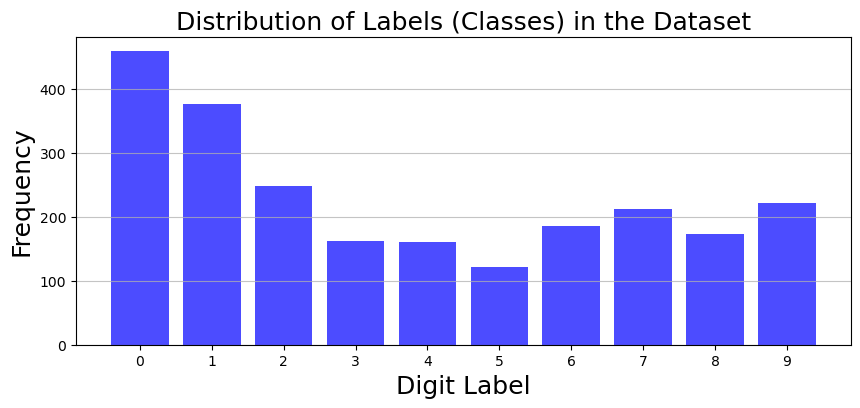

<Figure size 640x480 with 0 Axes>

In [3]:
#plot first char
def plot_char(char):
    data = char[1:].reshape(16, 16)
    plt.imshow(data, cmap='gray')
    plt.title(f"The number {char[0]}")
    plt.show()
print(zipcombo_qater[0].shape)
    
plot_char(zipcombo_qater[0])

def plot_label_distribution(labels):
    plt.figure(figsize=(10, 4),dpi=100)
    plt.hist(labels, bins=np.arange(11) - 0.5, rwidth=0.8, color='blue', alpha=0.7)
    plt.title("Distribution of Labels (Classes) in the Dataset",fontsize=18)
    plt.xlabel("Digit Label",fontsize=18)
    plt.ylabel("Frequency",fontsize=18)
    plt.xticks(range(10))
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    plt.savefig('label_distribution.png')
    
plot_label_distribution(y_labels)

In [67]:
##helper functions(can be extracted into a separate class later)

#polynomial kernel

def polynomial_kernel(p, q, d):
    return (1 + (p@q.T)) ** d

def gaussian_kernel_matrix(X1, X2, sigma):
    # It looks a little weird cause its vectorised
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-sigma * sq_dists)

#convering the data to -1 and 1
def mysign(data):
    return np.where(data <= 0.0, -1.0, 1.0)

def calculate_confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)))

    for true_class in classes:
        for pred_class in classes:
            if true_class != pred_class:  # Exclude diagonal elements
                matrix[true_class, pred_class] = np.sum((y_true == true_class) & (y_pred == pred_class)) / np.sum(y_true == true_class)

    return matrix

def calculate_confusion_matrix_std(confusion_matrices):
    return np.std(confusion_matrices, axis=0)

def plot_test_error(values, mean_test_errors_1vs1, optimizable_param_name, kernel_name):
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(values, mean_test_errors_1vs1*100, label='Test Error', marker='o', color='red')
    plt.title(f'Mean Test Error Rates vs Kernel {kernel_name} Parameters', fontsize=18)
    plt.xlabel(f'Optimizable Parameters {optimizable_param_name}', fontsize=18)
    plt.ylabel('Error Rate (%)', fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

In [5]:
# def train_kernel_perceptron_online(X, y, K, n_classes, return_training_error=True):
#     NB_EPOCHS_MAX = 30
#     num_samples = X.shape[0]
#     alpha = np.zeros((n_classes, num_samples))
#     prev_error = float('inf') 
#     epoches = 0
#     for epoch in range(NB_EPOCHS_MAX):
#         total_mistakes = 0
#         for i in range(num_samples):
#             scores = np.zeros(n_classes)
            
#             scores = K[i]@alpha.T
#             predicted_class = np.argmax(scores)
#             true_class = y[i]

#             if predicted_class != true_class:
#                 alpha[true_class, i] += 1
#                 alpha[predicted_class, i] -=1
#                 total_mistakes += 1  # Increment the total number of mistakes
                
#         epoches+=1     
#         print(f"Epoch {epoch+1}, number of samples {num_samples}, mistakes this epoch {total_mistakes}")
              
#         train_error = total_mistakes / num_samples  # Calculate the training error
        
#         # convergence
#         if (prev_error - train_error) < 1e-2:
#             break
#         prev_error = train_error
#     if(return_training_error):
#         return alpha, train_error
    
#     return alpha

In [69]:
# def predict_kernel_perceptron(alpha, y, K, return_labels=False):
#     # Calculate the scores for all test samples and classes at once
#     scores = np.dot(alpha, K.T)

#     # Predict the class with the highest score for each test sample
#     y_pred = np.argmax(scores, axis=0)

#     test_error = np.mean(y != y_pred)
#     if(return_labels):
#         return test_error, y_pred
#     return test_error

In [7]:
#same but in a class

class KernelPerceptron:
    def __init__(self, n_classes, kernel_function, kernel_param):
        self.n_classes = n_classes
        self.kernel_function = kernel_function
        self.kernel_param = kernel_param
        self.alpha = None
        self.train_data = None

    def fit(self, X_train, y_train, return_training_error=True):
        NB_EPOCHS_MAX = 30
        num_samples = X_train.shape[0]
        self.alpha = np.zeros((self.n_classes, num_samples))
        self.train_data = X_train
        K = self.kernel_function(X_train, X_train, self.kernel_param)
        prev_error = float('inf') 
        epoches = 0
        for epoch in range(NB_EPOCHS_MAX):
            total_mistakes = 0
            for i in range(num_samples):
                scores = np.zeros(self.n_classes)

                scores = K[i]@self.alpha.T
                predicted_class = np.argmax(scores)
                true_class = y_train[i]

                if predicted_class != true_class:
                    self.alpha[true_class, i] += 1
                    self.alpha[predicted_class, i] -=1
                    total_mistakes += 1  # Increment the total number of mistakes

            epoches+=1     
            print(f"Epoch {epoch+1}, number of samples {num_samples}, mistakes this epoch {total_mistakes}")

            train_error = total_mistakes / num_samples  # Calculate the training error

            # convergence
            if (prev_error - train_error) < 1e-2:
                break
            prev_error = train_error
        if(return_training_error):
            return train_error

    def predict(self, X_test, y_test, return_labels=False):
        # Calculate the scores for all test samples and classes at once
        K = self.kernel_function(X_test, self.train_data, self.kernel_param)
        scores = np.dot(self.alpha, K.T)

        # Predict the class with the highest score for each test sample
        y_pred = np.argmax(scores, axis=0)

        test_error = np.mean(y_test != y_pred)
        if(return_labels):
            return test_error, y_pred
        return test_error

## Q1

In [8]:
N_RUNS = 20
d_range = np.arange(1, 8, dtype=int)  # k = 1...7
#substitute for the real data with 10

#can be extraced from data
n_classes = len(np.unique(y_labels))

def run_experiment_without_cross_val(x_data, y_labels, N_RUNS, params_range, n_classes, kernel_function: callable, Classifier):
    '''
    Runs the experiment with the given kernel function and parameters range n_runs times
    :param x_data: the data
    :param y_labels: the labels
    :param N_RUNS: number of runs
    :param params_range: the range of the parameters
    :param n_classes: number of classes
    :param kernel_function: the kernel function
    :return: mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors
    '''
    train_errors = np.zeros((N_RUNS, len(params_range)))
    #train_errors2 = np.zeros((N_RUNS, len(params_range)))
    test_errors = np.zeros((N_RUNS, len(params_range)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(params_range):
            model = Classifier(n_classes, kernel_function, j)
            
            train_errors[i_run, j_ind] = model.fit(X_train, y_train)
            #train_errors2[i_run, j_ind] = model.predict(X_train, y_train)

            print(f"Run {i_run}, degree {j}, train error {train_errors[i_run, j_ind]}, number of samples {n_training_samples}")
            #print(f"Run {i_run}, degree {j}, train error 2 {train_errors2[i_run, j_ind]}, number of samples {n_training_samples}")
            
            # calculating prediction of the test data
            #K_test = kernel_function(X_test, X_train, j)
            test_errors[i_run, j_ind] = model.predict(X_test, y_test)
            print(f"Run {i_run}, degree {j}, test error {test_errors[i_run, j_ind]}, number of samples {len(X_test)}")

    mean_train_errors = (np.mean(train_errors, axis=0))
    mean_test_errors = np.mean(test_errors, axis=0)
    mean_std_train_errors = np.std(train_errors, axis=0)
    mean_std_test_errors = np.std(test_errors, axis=0)
    
    return mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors



In [9]:
mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, d_range, n_classes, kernel_function=polynomial_kernel, Classifier=KernelPerceptron)

Epoch 1, number of samples 1859, mistakes this epoch 366
Epoch 2, number of samples 1859, mistakes this epoch 174
Epoch 3, number of samples 1859, mistakes this epoch 159
Run 0, degree 1, train error 0.085529854760624, number of samples 1859
Run 0, degree 1, test error 0.11182795698924732, number of samples 465
Epoch 1, number of samples 1859, mistakes this epoch 268
Epoch 2, number of samples 1859, mistakes this epoch 87
Epoch 3, number of samples 1859, mistakes this epoch 54
Epoch 4, number of samples 1859, mistakes this epoch 34
Epoch 5, number of samples 1859, mistakes this epoch 20
Run 0, degree 2, train error 0.010758472296933835, number of samples 1859
Run 0, degree 2, test error 0.04516129032258064, number of samples 465


Epoch 1, number of samples 1859, mistakes this epoch 225
Epoch 2, number of samples 1859, mistakes this epoch 64
Epoch 3, number of samples 1859, mistakes this epoch 27
Epoch 4, number of samples 1859, mistakes this epoch 26
Run 0, degree 3, train error 0.013986013986013986, number of samples 1859
Run 0, degree 3, test error 0.047311827956989246, number of samples 465
Epoch 1, number of samples 1859, mistakes this epoch 212
Epoch 2, number of samples 1859, mistakes this epoch 47
Epoch 3, number of samples 1859, mistakes this epoch 16
Epoch 4, number of samples 1859, mistakes this epoch 5
Run 0, degree 4, train error 0.0026896180742334587, number of samples 1859
Run 0, degree 4, test error 0.03870967741935484, number of samples 465
Epoch 1, number of samples 1859, mistakes this epoch 201
Epoch 2, number of samples 1859, mistakes this epoch 41
Epoch 3, number of samples 1859, mistakes this epoch 13
Epoch 4, number of samples 1859, mistakes this epoch 5
Run 0, degree 5, train error 0.0026

In [40]:
def create_summary_table(mean_train_errors, mean_std_train_errors, mean_test_errors, mean_std_test_errors, range, parameter_name='Polynomial degree '):
    # Create a summary table
    columns = ['parameter', 'Mean Train Error', 'Std Train Error', 'Mean Test Error', 'Std Test Error']

    # Take an average over all the runs
    kernel_perceptron = pd.concat((
        pd.DataFrame(np.round(mean_train_errors,5), columns=[columns[1]]),
        pd.DataFrame(np.round(mean_std_train_errors,5), columns=[columns[2]]),
        pd.DataFrame(np.round(mean_test_errors,5), columns=[columns[3]]),
        pd.DataFrame(np.round(mean_std_test_errors,5), columns=[columns[4]])), axis=1
    )
    kernel_perceptron.set_index(parameter_name + pd.Series(range).astype(str), inplace=True)
    kernel_perceptron.index.name = 'parameter'
    #kernel_perceptron = kernel_perceptron.style.format("{:.5f}")

    return kernel_perceptron


In [41]:
kernel_perceptron = create_summary_table(mean_train_errors, mean_std_train_errors, mean_test_errors, mean_std_test_errors, d_range)
kernel_perceptron

,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
parameter,,,,
Polynomial degree 1,0.05984,0.01040,0.08903,0.01366
Polynomial degree 2,0.01302,0.00562,0.05075,0.01122
Polynomial degree 3,0.01027,0.00553,0.04645,0.00675
Polynomial degree 4,0.00395,0.00232,0.04430,0.00759
Polynomial degree 5,0.00282,0.00313,0.04688,0.00946
Polynomial degree 6,0.00304,0.00224,0.04763,0.00847
Polynomial degree 7,0.00355,0.00315,0.04677,0.00799


In [68]:
plot_test_errors(mean_test_errors, d_range, 'Polynomial degree')

NameError: name 'plot_test_errors' is not defined

In [12]:
def plot_error_rates(df_results, params_range, params_name, kernel_name):
    # Convert error rates to percentages
    df_results['Mean Train Error'] *= 100
    df_results['Mean Test Error'] *= 100
    df_results['Std Train Error'] *= 100
    df_results['Std Test Error'] *= 100

    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 5),dpi=100)

    # Plotting mean train error rates
    sns.lineplot(x=params_range, y='Mean Train Error', data=df_results,
                 label='Train Error', marker='o', color='blue')

    # Add error bars for train error
    plt.errorbar(params_range, df_results['Mean Train Error'],
                 yerr=df_results['Std Train Error'], fmt='none', capsize=5, color='blue')

    # Plot mean test error rates
    sns.lineplot(x=params_range, y='Mean Test Error', data=df_results,
                 label='Test Error', marker='o', color='red')

    # Add error bars for test error
    plt.errorbar(params_range, df_results['Mean Test Error'],
                 yerr=df_results['Std Test Error'], fmt='none', capsize=5, color='red')

    plt.title(f'Mean Train and Test Error Rates vs Kernel {kernel_name} Parameters',fontsize=18)
    plt.xlabel(f'Optimizable Parameters {params_name}',fontsize=18)
    plt.ylabel('Error Rate (%)',fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()

    # Show the plot
    plt.show()
    plt.savefig('error_rates_poly.png')
    

c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

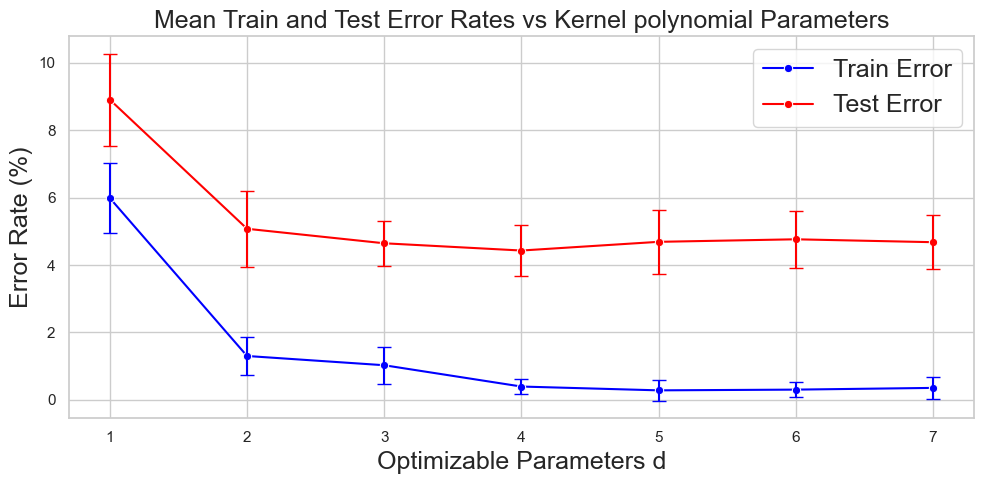

<Figure size 640x480 with 0 Axes>

In [13]:
plot_error_rates(kernel_perceptron, d_range, 'd', 'polynomial')

## Q2

In [14]:
N_FOLDS = 5

def run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, params_range, n_classes, kernel_function: callable, Classifier):
    '''
    Runs the kernel perceptron with cross validation
    param x_data: the data
    param y_labels: the labels
    param N_RUNS: number of runs
    param N_FOLDS: number of folds
    param range: the range of d's or c to test
    param n_classes: number of classes
    param kernel_function: the kernel function to use
    return: test_errors, d_stars, confusion_matrices, misclassified_images
    '''
    fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
    test_errors = np.zeros(shape=(N_RUNS))
    confusion_matrices = np.zeros(shape=(N_RUNS, n_classes, n_classes))
    misclassified_images = {}
    test_errors = np.zeros(N_RUNS)
    star_params = []
    fold_test_prediction_error = np.zeros((N_RUNS, N_FOLDS, len(params_range)))

    #loop over the runs
    for i_run in range(N_RUNS):
        #split the data into train and test
        X_train, X_test, Y_train, Y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        #create the folds
        folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)
        #loop over the folds
        for i_fold, fold in enumerate(folds_data):
            #loop over the d's
            for i_j, j in enumerate(params_range):
                #calculate the kernel matrix for the train and test data
                model_train = Classifier(n_classes, kernel_function, j)
                
                #train the kernel perceptron
                model_train.fit(fold.train_data, fold.train_labels, return_training_error=False)
                #calculate the prediction error for each run, fold and d
                fold_test_prediction_error[i_run, i_fold, i_j] = model_train.predict(fold.test_data, fold.test_labels)

        #calculate the d_star/c_star for each run
        star_param, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=params_range)
        star_params.append(star_param)
        model_test = Classifier(n_classes, kernel_function, star_param)
        #train the kernel perceptron with the d_star/c_star
        model_test.fit(X_train, Y_train, return_training_error=False)
        #calculate the test error for each run and d_star/c_star
        test_errors[i_run], y_pred = model_test.predict(X_test, Y_test, return_labels=True)
        
        #calculate the confusion matrix for each run and d_star/c_star
        confusion_matrices[i_run, :, :] = calculate_confusion_matrix(Y_test, y_pred)
        
        #record the misclassified images for each run and d_star/c_star
        misclassified_indices = np.where(y_pred!=Y_test)[0]
        misclassified_images[i_run] = {}
        for index in misclassified_indices:
            true_label = Y_test[index]
            misclassified_images[i_run][true_label] = X_test[index]

    return test_errors, star_params, confusion_matrices, misclassified_images


In [15]:
test_errors_poly, d_stars, confusion_matrices, misclassified_images = run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, d_range, n_classes, kernel_function=polynomial_kernel, Classifier=KernelPerceptron)
print(d_stars)
print(test_errors_poly)
def calculate_mean_star_param_and_mean_test_error_with_std(test_errors, stars_param, param):
    mean_cross_validation_test_error_with_star_param = np.mean(test_errors, axis=0)
    mean_cross_validation_test_error_std_with_star_param = np.std(test_errors, axis=0)
    mean_cross_validation_star_param = np.mean(stars_param)
    mean_cross_validation_std_star_param = np.std(stars_param)
    print("Mean Test Error {param}: ", mean_cross_validation_test_error_with_star_param, "±", mean_cross_validation_test_error_std_with_star_param)
    print("Mean Best {param}", mean_cross_validation_star_param, "±", mean_cross_validation_std_star_param)

    part_2_results = {
            f"Mean Best {param}": mean_cross_validation_star_param,
            f"Mean Best {param} standard deviation": mean_cross_validation_std_star_param,
            "Mean Test Error": mean_cross_validation_test_error_with_star_param,
            "Test Error Standard Deviation": mean_cross_validation_test_error_std_with_star_param
        }

    df_results_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
    df_results_2.reset_index(inplace=True)
    
    return df_results_2, mean_cross_validation_star_param

df_results_2, mean_cross_validation_d_star = calculate_mean_star_param_and_mean_test_error_with_std(test_errors_poly, d_stars, 'd')
df_results_2


Epoch 1, number of samples 1488, mistakes this epoch 341
Epoch 2, number of samples 1488, mistakes this epoch 164
Epoch 3, number of samples 1488, mistakes this epoch 123
Epoch 4, number of samples 1488, mistakes this epoch 109
Epoch 1, number of samples 1488, mistakes this epoch 259
Epoch 2, number of samples 1488, mistakes this epoch 69
Epoch 3, number of samples 1488, mistakes this epoch 36
Epoch 4, number of samples 1488, mistakes this epoch 20
Epoch 5, number of samples 1488, mistakes this epoch 18
Epoch 1, number of samples 1488, mistakes this epoch 215
Epoch 2, number of samples 1488, mistakes this epoch 41
Epoch 3, number of samples 1488, mistakes this epoch 19
Epoch 4, number of samples 1488, mistakes this epoch 5
Epoch 1, number of samples 1488, mistakes this epoch 199
Epoch 2, number of samples 1488, mistakes this epoch 38
Epoch 3, number of samples 1488, mistakes this epoch 12
Epoch 4, number of samples 1488, mistakes this epoch 1
Epoch 1, number of samples 1488, mistakes t

,index,0
0,Mean Best d,5.150000
1,Mean Best d standard deviation,1.275735
2,Mean Test Error,0.045699
3,Test Error Standard Deviation,0.007720


## Q3

In [16]:
def plot_confusion_matrix(confusion_matrices):
    std_dev_matrix = calculate_confusion_matrix_std(confusion_matrices)
    mean_confusion_matrix = confusion_matrices.mean(axis=0)
    combined_matrix = np.vectorize(lambda mean, std: f"{mean*100:.2f}% \n± \n{std*100:.2f}%")(mean_confusion_matrix, std_dev_matrix)

    plt.figure(figsize=(12, 10), dpi=80)
    sns.set(style="whitegrid", font_scale=1.1)
    ax = sns.heatmap(mean_confusion_matrix, annot=combined_matrix, fmt="", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 12}, xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title("Error Rate and Standard Deviation", fontsize=19)
    plt.xlabel('Predicted Label', fontsize=19)
    plt.ylabel('True Label', fontsize=19)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.savefig('confusion_matrix.png')
    


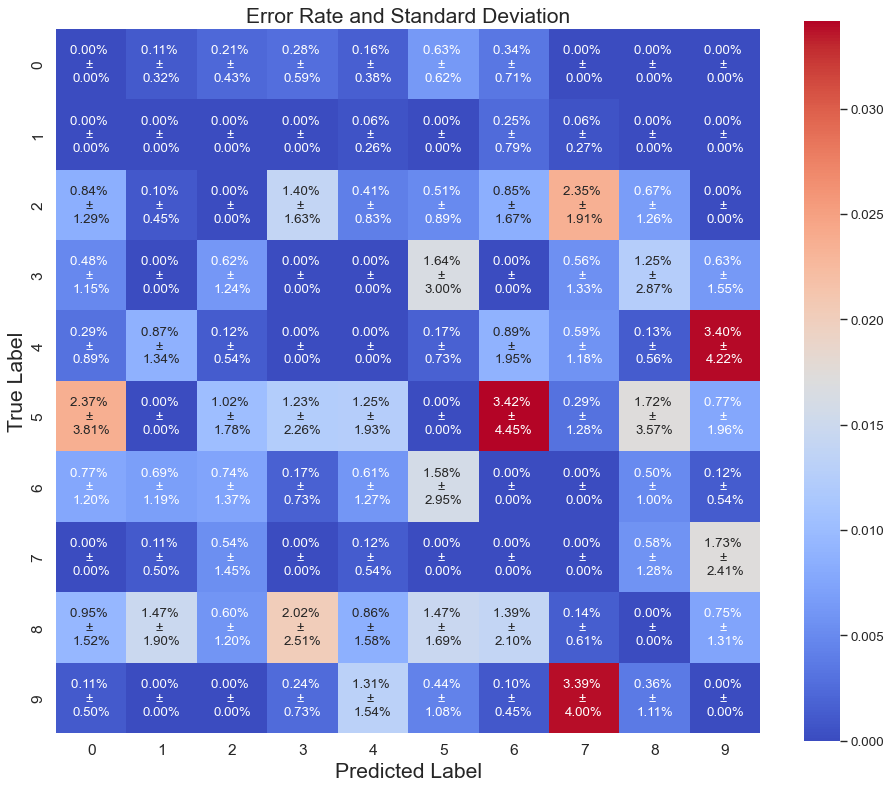

<Figure size 640x480 with 0 Axes>

In [17]:
plot_confusion_matrix(confusion_matrices)

## Q4

Counter({2: 20, 8: 20, 6: 19, 5: 18, 4: 18, 9: 17, 0: 15, 3: 14, 7: 14, 1: 4})


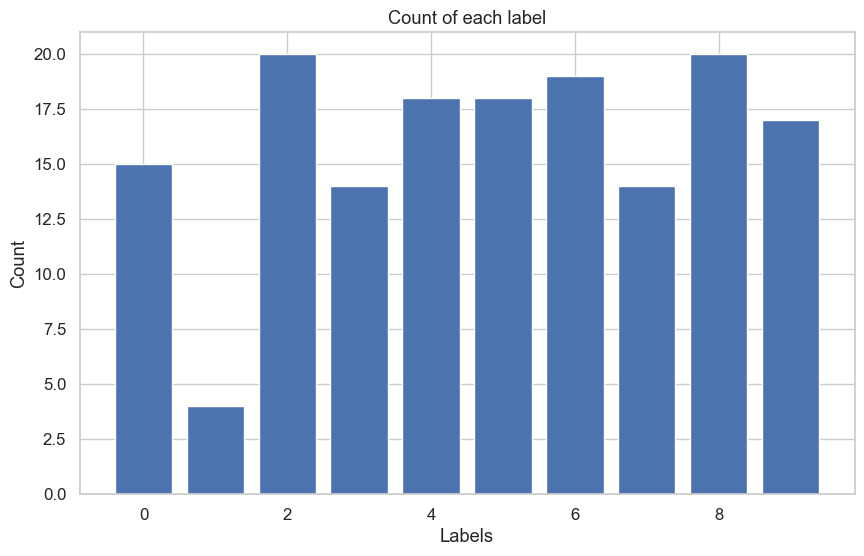

In [18]:
def plot_label_counts(label_counts):
    plt.figure(figsize=(10,6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Count of each label')
    plt.show()
    
def get_first_image_by_label(label):
    for image_dict in image_data:
        if image_dict['label'] == label:
            return image_dict['image']

# Initialize counters and data list
label_counts = Counter()
image_counts = Counter()
image_data = []

def count_labels_and_images(misclassified_images, label_counts, image_counts, image_data):
    # Count labels and images
    for i_run, labels in misclassified_images.items():
        for label, image in labels.items():
            image = tuple(image.flatten())
            label_counts[label] += 1
            image_counts[image] += 1

            # Add new image data or update count of existing image data
            for image_dict in image_data:
                if image_dict['image'] == image:
                    image_dict['count'] = image_counts[image]
                    break
            else:
                image_data.append({'image': image, 'count': image_counts[image], 'label': label})
    return label_counts, image_counts, image_data

label_counts, image_counts, image_data = count_labels_and_images(misclassified_images, label_counts, image_counts, image_data)

# Sort image data by count in descending order
image_data.sort(key=lambda x: x['count'], reverse=True)
print(label_counts)

# Get the 5 most common images
most_common_images = image_data[:5]
most_common_labels = label_counts.most_common(5)

############plots for report
plot_label_counts(label_counts)

def plot_common_labels_and_images(most_common_labels, most_common_images, get_first_image_by_label):
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # Create a figure with 2 rows of 5 subplots
    fig.suptitle('Most Common Labels and corresponding top misclassified images', fontsize=20)

    for ax, (label, count) in zip(axes[1], most_common_labels):  # Use the second row of subplots
        image1 = np.array(get_first_image_by_label(label)).reshape(16, 16)
        ax.imshow(image1, cmap='gray')
        ax.axis('off')
        ax.set_title(f" Digit {label} occurs {count} times", fontsize=16)
        
    # Display each of the 5 most common images in its own subplot
    for ax, data in zip(axes[0], most_common_images):  # Use the first row of subplots
        image, count, label = data['image'], data['count'], data['label']
        image = np.array(image).reshape(16, 16)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"This image with digit {label} occurs {count} times", fontsize=16)

    plt.show()



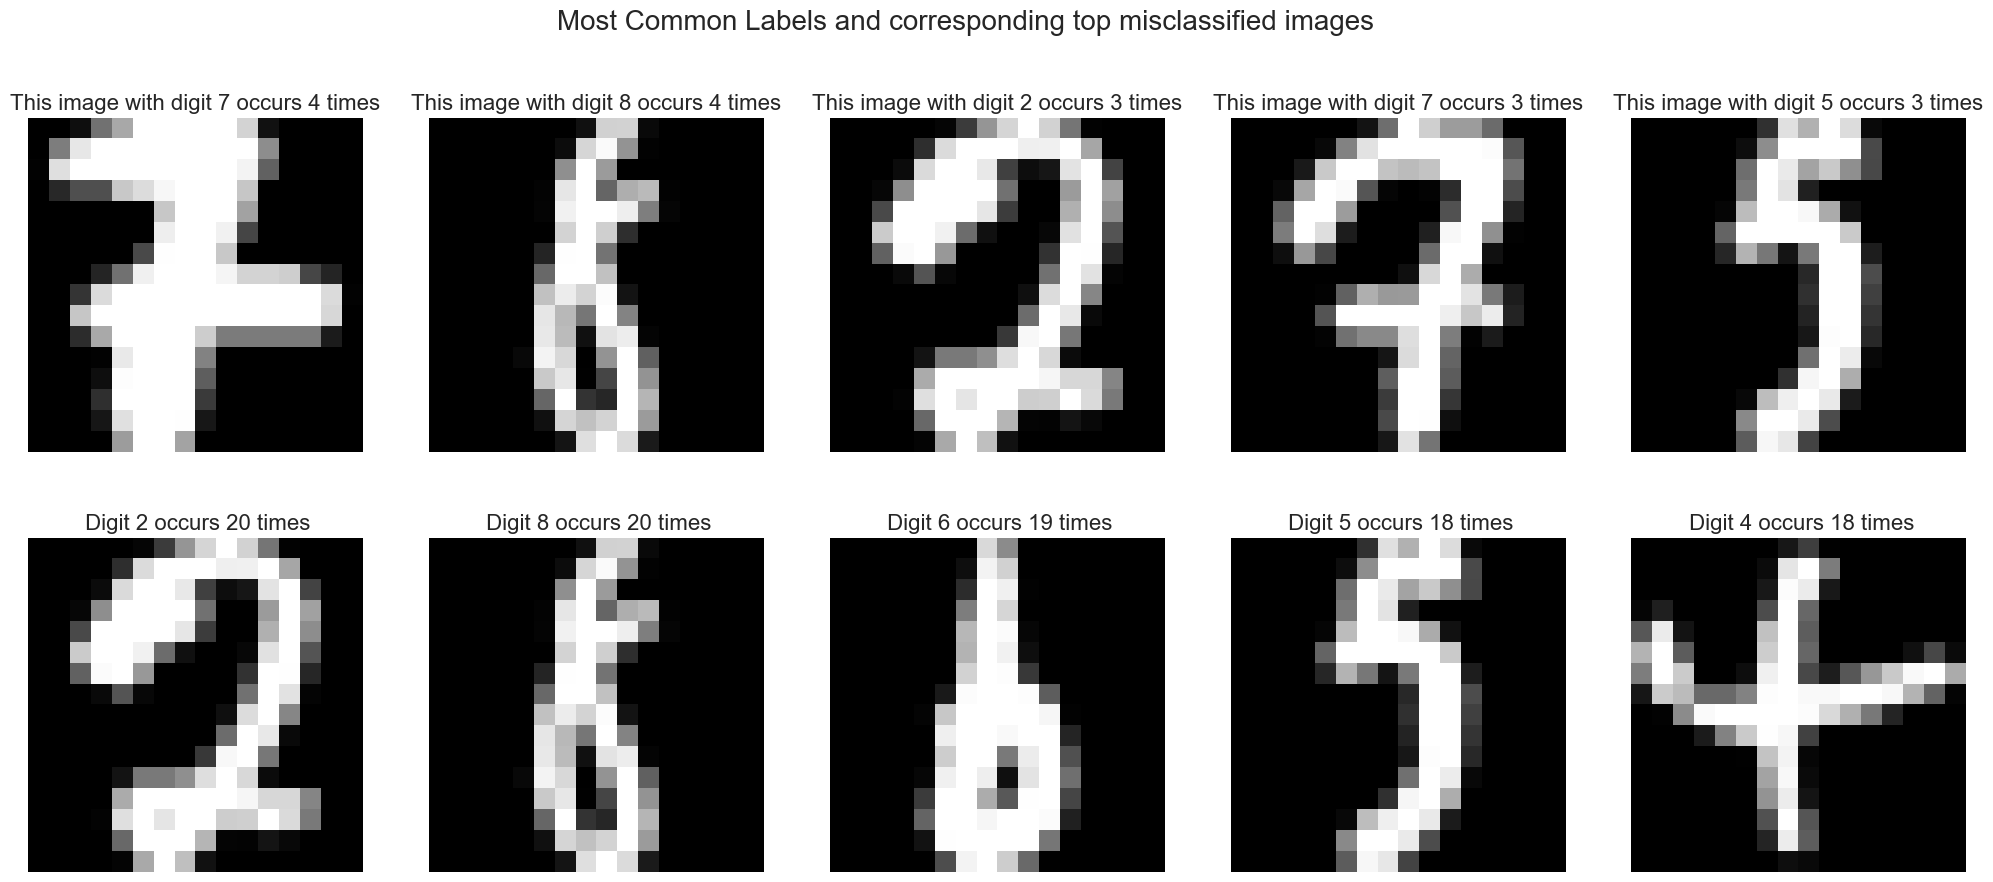

In [19]:
plot_common_labels_and_images(most_common_labels, most_common_images, get_first_image_by_label)

In [20]:
# most_misclassified_label = max(label_counts, key=label_counts.get)
# label_counter = Counter(label_counts)
# most_common_labels = label_counter.most_common(5)
# most_misclassified_images = []
# for i_run in misclassified_images:
#     if most_misclassified_label in misclassified_images[i_run]:
#         most_misclassified_images.append(misclassified_images[i_run][most_misclassified_label])

# fig, axes = plt.subplots(1, len(most_misclassified_images), figsize=(15, 5))

# for ax, image in zip(axes, most_misclassified_images):
    
#     data = image.reshape(16, 16)
#     ax.imshow(data, cmap='gray')
#     ax.axis('off')

# plt.show()

## Q5

In [21]:
c_range = [0.001, 0.01, 0.1, 1, 10, 100]
mean_train_errors_gauss, mean_test_errors_gauss, mean_std_train_errors_gauss, mean_std_test_errors_gauss = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, c_range, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=KernelPerceptron)

Epoch 1, number of samples 1859, mistakes this epoch 525
Epoch 2, number of samples 1859, mistakes this epoch 242
Epoch 3, number of samples 1859, mistakes this epoch 192
Epoch 4, number of samples 1859, mistakes this epoch 162
Epoch 5, number of samples 1859, mistakes this epoch 130
Epoch 6, number of samples 1859, mistakes this epoch 118
Run 0, degree 0.001, train error 0.06347498655190963, number of samples 1859
Run 0, degree 0.001, test error 0.09247311827956989, number of samples 465
Epoch 1, number of samples 1859, mistakes this epoch 216
Epoch 2, number of samples 1859, mistakes this epoch 44
Epoch 3, number of samples 1859, mistakes this epoch 26
Run 0, degree 0.01, train error 0.013986013986013986, number of samples 1859
Run 0, degree 0.01, test error 0.047311827956989246, number of samples 465
Epoch 1, number of samples 1859, mistakes this epoch 225
Epoch 2, number of samples 1859, mistakes this epoch 38
Epoch 3, number of samples 1859, mistakes this epoch 2
Epoch 4, number o

In [22]:
# Create a summary table
columns = ['sigma', 'Mean Train Error', 'Std Train Error', 'Mean Test Error', 'Std Test Error']

# Take an average over all the runs
kernel_perceptron_gauss = pd.concat((
    pd.DataFrame(mean_train_errors_gauss, columns=[columns[1]]),
    pd.DataFrame(mean_std_train_errors_gauss,columns=[columns[2]]),
    pd.DataFrame(mean_test_errors_gauss, columns=[columns[3]]),
    pd.DataFrame(mean_std_test_errors_gauss, columns=[columns[4]])), axis=1
)
kernel_perceptron_gauss.set_index((pd.Series(c_range, name='c')), inplace=True)
kernel_perceptron_gauss.index.name = 'sigma'

kernel_perceptron_gauss

,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
sigma,,,,
0.001,0.078107,0.011179,0.118925,0.034261
0.010,0.007370,0.003183,0.046022,0.008903
0.100,0.000134,0.000477,0.067419,0.008054
1.000,0.000027,0.000117,0.075699,0.009822
10.000,0.000108,0.000323,0.256452,0.015976
100.000,0.000000,0.000000,0.679032,0.017122


c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alina\miniconda3\envs\MV00\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

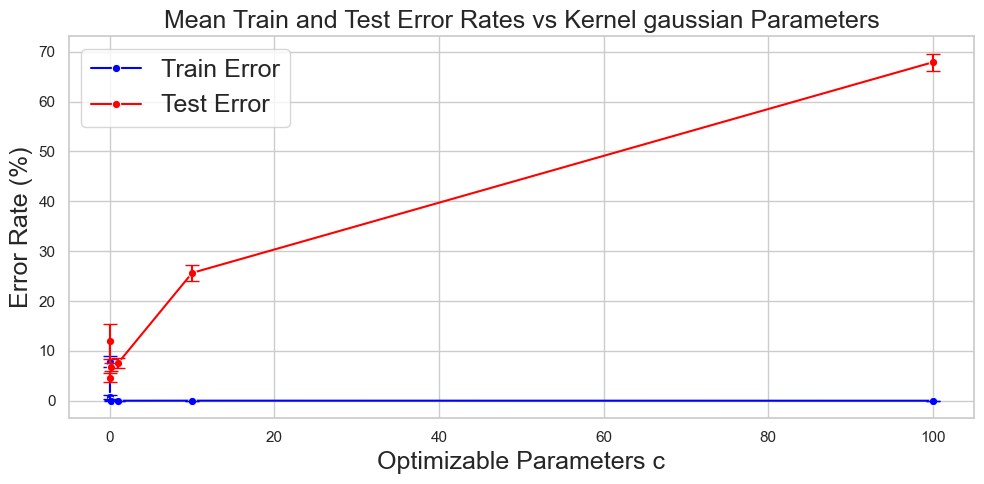

<Figure size 640x480 with 0 Axes>

In [23]:

plot_error_rates(kernel_perceptron_gauss, c_range, 'c', 'gaussian')

In [24]:
new_c_range = [0.001, 0.01, 0.03, 0.1, 0.3, 1]
test_errors_gauss, c_stars, confusion_matrices, misclassified_images = run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, new_c_range, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=KernelPerceptron)

Epoch 1, number of samples 1488, mistakes this epoch 453
Epoch 2, number of samples 1488, mistakes this epoch 220
Epoch 3, number of samples 1488, mistakes this epoch 168
Epoch 4, number of samples 1488, mistakes this epoch 138
Epoch 5, number of samples 1488, mistakes this epoch 141
Epoch 1, number of samples 1488, mistakes this epoch 212
Epoch 2, number of samples 1488, mistakes this epoch 40
Epoch 3, number of samples 1488, mistakes this epoch 14
Epoch 4, number of samples 1488, mistakes this epoch 4
Epoch 1, number of samples 1488, mistakes this epoch 183
Epoch 2, number of samples 1488, mistakes this epoch 30
Epoch 3, number of samples 1488, mistakes this epoch 8
Epoch 4, number of samples 1488, mistakes this epoch 0
Epoch 1, number of samples 1488, mistakes this epoch 191
Epoch 2, number of samples 1488, mistakes this epoch 39
Epoch 3, number of samples 1488, mistakes this epoch 10
Epoch 4, number of samples 1488, mistakes this epoch 0
Epoch 1, number of samples 1488, mistakes th

In [25]:
c_stars
test_errors_gauss
print(c_stars)
print(test_errors_gauss)

[0.03, 0.01, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.01, 0.03, 0.03, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01, 0.01]
[0.0516129  0.02580645 0.04731183 0.04516129 0.04731183 0.04301075
 0.04301075 0.04516129 0.03655914 0.04086022 0.0344086  0.0516129
 0.04731183 0.05591398 0.0516129  0.04086022 0.05806452 0.03655914
 0.04301075 0.05591398]


In [26]:
df_c_star_results, mean_cross_validation_c_star = calculate_mean_star_param_and_mean_test_error_with_std(test_errors_gauss, c_stars, 'c')
df_c_star_results

Mean Test Error {param}:  0.04505376344086022 ± 0.007827336617270277
Mean Best {param} 0.017000000000000005 ± 0.009539392014169455


,index,0
0,Mean Best c,0.017000
1,Mean Best c standard deviation,0.009539
2,Mean Test Error,0.045054
3,Test Error Standard Deviation,0.007827


## Q6

DO 20 runs without cross validation

In [27]:
def calculate_accuracy(actual, predicted):
    return np.mean(actual == predicted)


def softmax(x):
    # Subtracting the max can help with numerical stability
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)


def make_probabilistic_predictions(kappas):
    """
    How does this function work?
    - We'll take in our kappas (confidence vectors)
    - We'll convert them to probabilities using softmax
    - Then we can sample from the probabilities
    """
    predictions = []
    for kappa in kappas:
        # Convert kappa to probabilities using softmax
        kappa = np.expand_dims(kappa, axis=0)  # Ensure kappa is a 2D array
        probabilities = softmax(kappa)
        
        # Now we can sample from the probabilities
        predictions.append(np.random.choice(len(probabilities[0]), p=probabilities[0]))
    return np.array(predictions)

In [28]:
from joblib import Parallel, delayed

class BinaryKernelPerceptron:
    # Lets make a binary classifier that can distinguish between two classes
    """
    Binary Kernel Perceptron
    We'll need to make a fitting function and a prediction function.
    The fitting function will take in our training data and train our model.
    The prediction function will take in our test data and return our predictions.

    alpha: The weights of our model
    train_data: The data we trained on
    kernel_matrix: The kernel matrix of our training data
    kernel_function: The kernel function we're using - Guassian for now
    kernel_param: The parameter for our kernel function - gamma for now
    """


    def __init__(self, kernel_function, kernel_param):
        self.kernel_function = kernel_function
        self.kernel_param = kernel_param
        self.alpha = None
        self.train_data = None

    def fit(self, X, y, tolerance=0.01, max_epochs=10):
        self.alpha = np.zeros(X.shape[0])
        self.train_data = X
        # It makes it a bit more efficient to precompute the kernel matrix
        self.kernel_matrix = self.kernel_function(X, X, self.kernel_param)

        for epoch in range(max_epochs):
            # Now for the core logic of the perceptron algorithm
            predictions = np.sign(np.dot(self.kernel_matrix, self.alpha))
            # We'll update our weights based on the errors we made
            errors = (y * predictions <= 0) # Where did we make errors?
            self.alpha[errors] += y[errors] # Go to those classes and update our weights
            # As a sort of early stopping
            if np.sum(errors) / X.shape[0] < tolerance:
                break

    def predict(self, X):
        # We need to compute the kernel matrix between our test data and our training data
        kernel_values = self.kernel_function(X, self.train_data, self.kernel_param)
        # And then do the dot product between our weights and the kernel matrix
        return np.sign(np.dot(kernel_values, self.alpha))

class OneVsOneKernelPerceptron:
    """
    This class will take in a number of classes and train a binary classifier for each pair of classes.
    So for a large number of classes, it wont be quite as effient as our previous One-vs-Rest classifier.
    So how will we build it?
    - We'll need to train a binary classifier for each pair of classes
    - We'll need to predict using each classifier
    - Then find the class with the most votes
    - If we normalise those votes it would make kappa (a confidence vector)
    - Then to get a final prediction we could either take the class with the highest kappa value or sample from the distribution
    """
    def __init__(self, n_classes, kernel_function, kernel_param):
        self.n_classes = n_classes
        self.kernel_function = kernel_function
        self.kernel_param = kernel_param
        self.classifiers = {} # We will end up with k(k-1)/2 classifiers where k=10. So 45
    
    @staticmethod
    def fit_binary_classifier(class1, class2, X, y, kernel_function, kernel_param, **fit_params):
        idx = np.where((y == class1) | (y == class2))[0]
        X_pair, y_pair = X[idx], y[idx]
        y_pair = np.where(y_pair == class1, 1, -1)
        classifier = BinaryKernelPerceptron(kernel_function, kernel_param)
        classifier.fit(X_pair, y_pair, **fit_params)
        return (class1, class2), classifier

    def fit(self, X, y, return_training_error=True, **fit_params):
        X = X.astype(np.float32)
        results = Parallel(n_jobs=-1)(delayed(self.fit_binary_classifier)(class1, class2, X, y, self.kernel_function, self.kernel_param, **fit_params) for class1, class2 in combinations(range(self.n_classes), 2))
        self.classifiers = dict(results)
        if return_training_error:
            return self.predict(X, y)


    def predict(self, X, y,return_labels=False, return_confidences=False):
        X = X.astype(np.float32)
        # The votes will be a matrix of shape (num_samples, num_classes)
        # So each row will be the number of votes for each class, so to get the final prediction we could just take the argmax
        votes = np.zeros((X.shape[0], self.n_classes))
        confidences = np.zeros((X.shape[0], self.n_classes))

        for (class1, class2), classifier in self.classifiers.items():
            predictions = classifier.predict(X)
            # Ok, so to update the votes we need to add 1 to the class we predicted and -1 to the class we didn't predict
            votes[:, class1] += (predictions == 1)
            votes[:, class2] += (predictions == -1)
            confidences[:, class1] += (predictions == 1) * np.sum(classifier.alpha[classifier.alpha > 0])
            confidences[:, class2] += (predictions == -1) * np.sum(classifier.alpha[classifier.alpha > 0])
        
        y_pred = np.argmax(votes, axis=1)
        error_rate = np.mean(y != y_pred)

        if return_confidences:
            return error_rate, y_pred, confidences
        if return_labels:
            return error_rate, y_pred
        else:
            return error_rate



(Max Confidence) Kernelised Perceptron Accuracy: 96.56%
(Sampled from Kappa) Kernelised Perceptron Accuracy: 69.68%


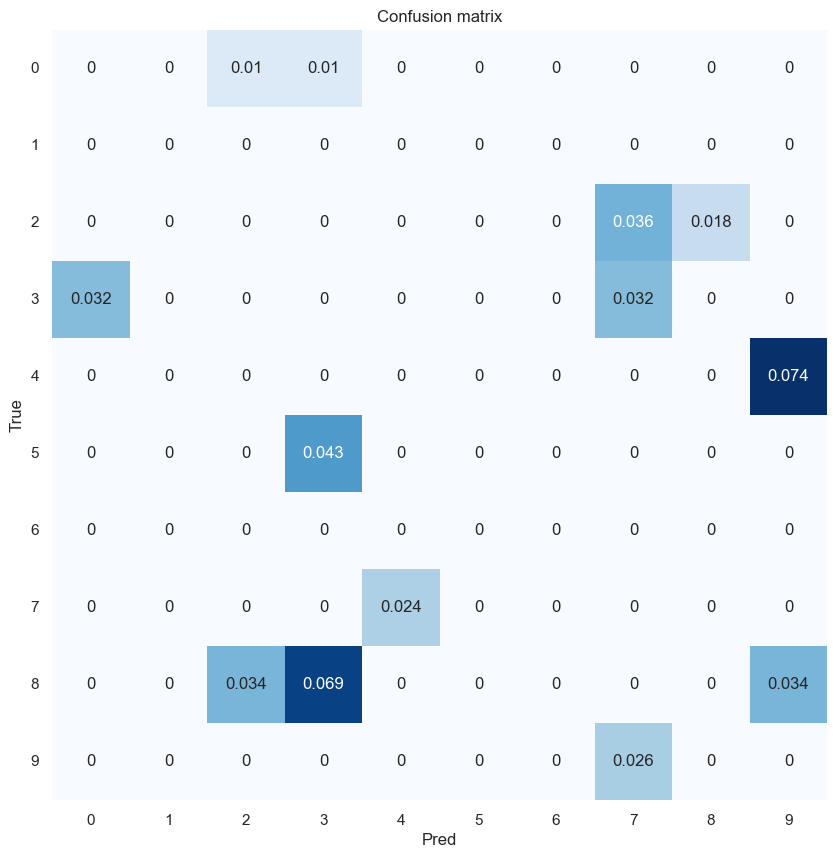

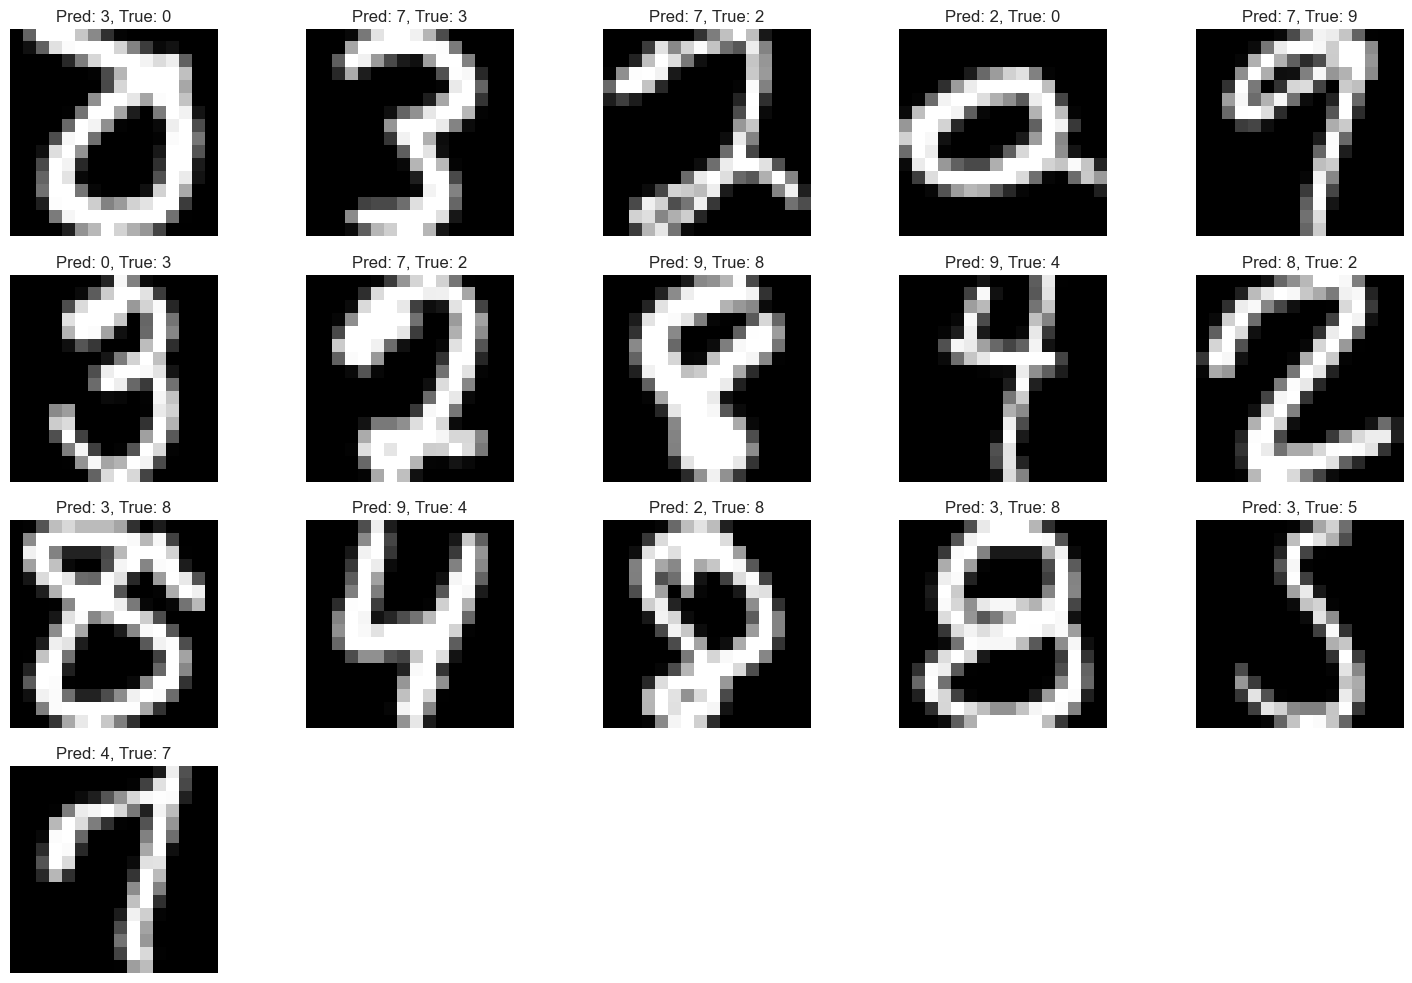

In [29]:
# Training and prediction
gamma = 0.47
X_train, X_test, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.2)
classifier = OneVsOneKernelPerceptron(n_classes, gaussian_kernel_matrix, kernel_param=gamma)
training_error = classifier.fit(X_train, y_train, True, max_epochs=100, tolerance=0.001)
error_rate, predictions, kappas = classifier.predict(X_test, y_test, return_confidences=True)

# Accuracy calculation and display
accuracy = calculate_accuracy(y_test, predictions)
prob_accuracy = calculate_accuracy(y_test, make_probabilistic_predictions(kappas))
print(f"(Max Confidence) Kernelised Perceptron Accuracy: {accuracy:.2%}")
print(f"(Sampled from Kappa) Kernelised Perceptron Accuracy: {prob_accuracy:.2%}")

# Confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(calculate_confusion_matrix(y_test, predictions), annot=True, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

# Incorrect predictions display
incorrect_indices = np.nonzero(predictions != y_test)[0]
fig, axes = plt.subplots(len(incorrect_indices) // 5 + 1, 5, figsize=(15, 3 * len(incorrect_indices) // 5 + 1))
axes = axes.flatten()

for i, index in enumerate(incorrect_indices):
    axes[i].imshow(X_test[index].reshape((16, 16)), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Pred: {predictions[index]}, True: {y_test[index]}")

for ax in axes[i+1:]:
    fig.delaxes(ax)
plt.tight_layout()
plt.show()

## Repeating q1 20 runs with gamma range 0.1, 0.5, 1, 2, 3

In [65]:
gamma_values = [0.05, 0.25, 0.5, 0.8, 1.2]
mean_train_errors_1vs1, mean_test_errors_1vs1, mean_std_train_errors_1vs1, mean_std_test_errors_1vs1 = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, gamma_values, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=OneVsOneKernelPerceptron)


Run 0, degree 0.05, train error 0.006455083378160301, number of samples 1859
Run 0, degree 0.05, test error 0.08602150537634409, number of samples 465
Run 0, degree 0.25, train error 0.0, number of samples 1859
Run 0, degree 0.25, test error 0.05591397849462366, number of samples 465
Run 0, degree 0.5, train error 0.0, number of samples 1859
Run 0, degree 0.5, test error 0.060215053763440864, number of samples 465
Run 0, degree 0.8, train error 0.0, number of samples 1859
Run 0, degree 0.8, test error 0.06451612903225806, number of samples 465
Run 0, degree 1.2, train error 0.0, number of samples 1859
Run 0, degree 1.2, test error 0.14838709677419354, number of samples 465
Run 1, degree 0.05, train error 0.006993006993006993, number of samples 1859
Run 1, degree 0.05, test error 0.07741935483870968, number of samples 465
Run 1, degree 0.25, train error 0.0, number of samples 1859
Run 1, degree 0.25, test error 0.030107526881720432, number of samples 465
Run 1, degree 0.5, train error 0

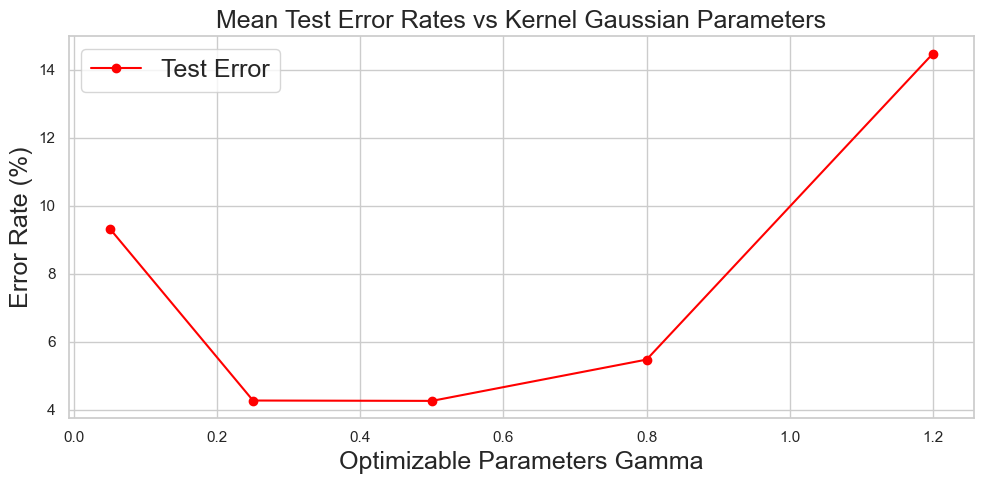

In [66]:
basic_results_oneVsOne = create_summary_table(mean_train_errors_1vs1, mean_std_train_errors_1vs1, mean_test_errors_1vs1, mean_std_test_errors_1vs1, gamma_values, parameter_name='Gamma ')
basic_results_oneVsOne

plot_test_error(gamma_values, mean_test_errors_1vs1, 'Gamma', 'Gaussian')

In [64]:
basic_results_oneVsOne

,Mean Train Error,Std Train Error,Mean Test Error,Std Test Error
parameter,,,,
Gamma 0.05,0.006,0.00069,0.09323,0.00984
Gamma 0.25,0.000,0.00000,0.04269,0.00853
Gamma 0.5,0.000,0.00000,0.04258,0.00931
Gamma 0.8,0.000,0.00000,0.05473,0.00994
Gamma 1.2,0.000,0.00000,0.14473,0.01241
Gamma 2.0,0.000,0.00000,0.35602,0.01906


In [32]:

# # I did some tests before and found that these values are a good range to search over
# gamma_values = np.array([0.1, 0.5, 1, 2, 3], dtype=np.float32)
# #mean_train_errors_gauss, mean_test_errors_gauss, mean_std_train_errors_gauss, mean_std_test_errors_gauss = run_experiment_without_cross_val(x_data, y_labels, N_RUNS, gamma_values, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=OneVsOneKernelPerceptron)

# results = {}

# for ind_gamma, gamma in enumerate(gamma_values):
#     # We would to store the train and test errors for each run (20 runs in total)
#     train_errors = []
#     test_errors = []

#     for i_run in range(20):
#         print(f"Gamma value: {gamma}, run: {i_run}")
#         # Get a fresh random split of the data
#         #train_labels, train_images, test_labels, test_images = get_fresh_random_data(zipcombo_data,random_state=run)
#         X_train, X_test, y_train, y_test = train_test_split(
#             x_data, y_labels, test_size=0.2, random_state=i_run
#         )

#         # Create an instance of OneVsOneKernelPerceptron with the gaussian_kernel and the current gamma
#         classifier = OneVsOneKernelPerceptron(n_classes, kernel_function=gaussian_kernel_matrix, kernel_param=gamma)
#         classifier.fit(X_train, y_train)

#         # Predict on the training data and calculate the training error rate
#         train_error_rate = classifier.predict(X_train, y_train)
#         #train_error_rate = np.mean(train_predictions != y_train)
#         train_errors.append(train_error_rate)

#         # Predict on the testing data and calculate the test error rate
#         test_error_rate = classifier.predict(X_test, y_test)
#         #test_error_rate = np.mean(test_predictions != y_test)
#         test_errors.append(test_error_rate)

#     # El Results
#     train_error_mean = np.mean(train_errors)
#     train_error_std = np.std(train_errors)
#     test_error_mean = np.mean(test_errors)
#     test_error_std = np.std(test_errors)

#     results[gamma] = {
#         'train_error_mean': train_error_mean,
#         'train_error_std': train_error_std,
#         'test_error_mean': test_error_mean,
#         'test_error_std': test_error_std,
#     }


In [33]:
# # Lets put these results into a tidy dataframe

df_basic_results = pd.DataFrame()
df_basic_results['gamma'] = gamma_values
df_basic_results['train_error_mean'] = [result['train_error_mean'] for result in results.values()]
df_basic_results['train_error_std'] = [result['train_error_std'] for result in results.values()]
df_basic_results['test_error_mean'] = [result['test_error_mean'] for result in results.values()]
df_basic_results['test_error_std'] = [result['test_error_std'] for result in results.values()]
df_basic_results.to_csv('basic_results.csv', index=False)
df_basic_results

In [34]:
# Lets interpolate to find the best gamma value (which would be the gamma that resulted in the lowest test error rate)

# Create a new dataframe with interpolated values
df_basic_results_interpolated = pd.DataFrame()
df_basic_results_interpolated['gamma'] = np.linspace(0.01, 3.0, 100)
df_basic_results_interpolated['test_error_mean'] = np.interp(df_basic_results_interpolated['gamma'], df_basic_results['gamma'], df_basic_results['test_error_mean'])
df_basic_results_interpolated['test_error_std'] = np.interp(df_basic_results_interpolated['gamma'], df_basic_results['gamma'], df_basic_results['test_error_std'])

# Find the gamma value with the lowest test error rate
best_gamma = df_basic_results_interpolated['gamma'][df_basic_results_interpolated['test_error_mean'].idxmin()]
print(f"Best gamma value: {best_gamma}")

# We could plot it as well
plt.figure(figsize=(10, 4),dpi=100)
plt.plot(df_basic_results_interpolated['gamma'], df_basic_results_interpolated['test_error_mean'])
plt.fill_between(df_basic_results_interpolated['gamma'], df_basic_results_interpolated['test_error_mean'] - df_basic_results_interpolated['test_error_std'], df_basic_results_interpolated['test_error_mean'] + df_basic_results_interpolated['test_error_std'], alpha=0.2)
plt.xlabel('Gamma', fontsize=16)
plt.ylabel('Test Error Rate', fontsize=16)
plt.title('Test Error Rate vs Gamma', fontsize=20)
plt.show()

NameError: name 'df_basic_results' is not defined

## Repeating Q2 cross validation

In [43]:
gamma_values = [0.05, 0.25, 0.4, 0.6, 0.8, 1.2]
test_errors_1vs1, gamma_stars, confusion_matrices, misclassified_images = run_kernel_perceptron_cross_val(x_data, y_labels, N_RUNS, N_FOLDS, gamma_values, n_classes, kernel_function=gaussian_kernel_matrix, Classifier=OneVsOneKernelPerceptron)
print(gamma_stars)
print(test_errors_1vs1)

[0.25, 0.25, 0.25, 0.4, 0.4, 0.25, 0.6, 0.25, 0.25, 0.6, 0.25, 0.25, 0.25, 0.4, 0.4, 0.4, 0.4, 0.25, 0.25, 0.4]
[0.05591398 0.03010753 0.04516129 0.0516129  0.0516129  0.04086022
 0.04301075 0.03010753 0.03870968 0.02795699 0.0516129  0.04086022
 0.04516129 0.04301075 0.04301075 0.04946237 0.05376344 0.02795699
 0.03655914 0.04516129]


In [54]:
def calculate_mean_star_param_and_mean_test_error_with_std(test_errors, stars_param, param):
    mean_cross_validation_test_error_with_star_param = np.mean(test_errors, axis=0)
    mean_cross_validation_test_error_std_with_star_param = np.std(test_errors, axis=0)
    mean_cross_validation_star_param = np.mean(stars_param)
    mean_cross_validation_std_star_param = np.std(stars_param)
    print("Mean Test Error {param}: ", mean_cross_validation_test_error_with_star_param, "±", mean_cross_validation_test_error_std_with_star_param)
    print("Mean Best {param}", mean_cross_validation_star_param, "±", mean_cross_validation_std_star_param)

    part_2_results = {
            f"Mean Best {param}": mean_cross_validation_star_param,
            f"Mean Best {param} standard deviation": mean_cross_validation_std_star_param,
            "Mean Test Error": mean_cross_validation_test_error_with_star_param,
            "Test Error Standard Deviation": mean_cross_validation_test_error_std_with_star_param
        }
    print('gamma', gamma_stars)

    df_results_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
    df_results_2.reset_index(inplace=True)
    
    ###########################FIXME
    # df_results = pd.DataFrame()
    # df_results[param] = gamma_values
    # df_results['test_error_mean'] = mean_cross_validation_test_error_with_star_param
    # df_results['test_error_std'] = mean_cross_validation_test_error_std_with_star_param

    # df_results_interpolated = pd.DataFrame()
    # df_results_interpolated[param] = np.linspace(min(gamma_values), max(gamma_values), 100)
    # df_results_interpolated['test_error_mean'] = np.interp(df_results_interpolated[param], df_results[param], df_results['test_error_mean'])
    # df_results_interpolated['test_error_std'] = np.interp(df_results_interpolated[param], df_results[param], df_results['test_error_std'])

    # # Plotting
    # plt.figure(figsize=(10, 4), dpi=100)
    # plt.plot(df_results_interpolated[param], df_results_interpolated['test_error_mean'])
    # plt.fill_between(df_results_interpolated[param], df_results_interpolated['test_error_mean'] - df_results_interpolated['test_error_std'], df_results_interpolated['test_error_mean'] + df_results_interpolated['test_error_std'], alpha=0.2)
    # plt.xlabel(param, fontsize=16)
    # plt.ylabel('Test Error Rate', fontsize=16)
    # plt.title('Test Error Rate vs ' + param, fontsize=20)
    # plt.show()
    
    return df_results_2, mean_cross_validation_star_param

df_results_2, mean_cross_validation_d_star = calculate_mean_star_param_and_mean_test_error_with_std(test_errors_1vs1, gamma_stars, 'gamma')
df_results_2

Mean Test Error {param}:  0.04258064516129032 ± 0.008400870961128865
Mean Best {param} 0.3375 ± 0.11166355717063647
gamma [0.25, 0.25, 0.25, 0.4, 0.4, 0.25, 0.6, 0.25, 0.25, 0.6, 0.25, 0.25, 0.25, 0.4, 0.4, 0.4, 0.4, 0.25, 0.25, 0.4]


,index,0
0,Mean Best gamma,0.337500
1,Mean Best gamma standard deviation,0.111664
2,Mean Test Error,0.042581
3,Test Error Standard Deviation,0.008401


In [ ]:
# def cross_validate_gamma(train_data, gamma, num_classes, kernel_function):
#     #kf = KFold(n_splits=5)
#     validation_errors = []
#     X_train, X_test, Y_train, Y_test = train_test_split(
#             x_data, y_labels, test_size=0.2, random_state=i_run
#         )
#     #create the folds
#     folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

#     for i_fold, fold in enumerate(folds_data):
#         #train_fold, val_fold = train_data[train_index], train_data[val_index]
#         classifier = OneVsOneKernelPerceptron(num_classes=num_classes, kernel_function=kernel_function, kernel_param=gamma)
#         classifier.fit(fold.train_data , fold.train_labels)
        
#         val_predictions = classifier.predict(fold.test_data)
#         validation_error = np.mean(val_predictions != fold.test_labels)
#         validation_errors.append(validation_error)

#     return np.mean(validation_errors)

In [ ]:
# import numpy as np

# # Define the gamma values and the number of runs
# gamma_values = [0.05,0.25,0.4,0.6,0.8,1.2]
# num_runs = 20

# # Initialize the lists to store the best gamma values and test errors for each run
# best_gammas = []
# test_errors = []


# # Adjusted main loop
# mean_validation_errors = []

# for run in tqdm(range(num_runs)):
#     train_data, test_data = train_test_split(zipcombo_data, test_size=0.2, random_state=run)

#     # Parallel processing for different gamma values
#     validation_errors_for_gammas = Parallel(n_jobs=-1)(delayed(cross_validate_gamma)(train_data, gamma, 10, gaussian_kernel) for gamma in gamma_values)
#     best_gamma = gamma_values[np.argmin(validation_errors_for_gammas)]
#     best_gammas.append(best_gamma)

#     classifier = OneVsOneKernelPerceptron(num_classes=10, kernel_function=gaussian_kernel, kernel_param=best_gamma)
#     classifier.fit(train_data[:, 1:], train_data[:, 0])

#     test_predictions = classifier.predict(test_data[:, 1:])
#     test_error = np.mean(test_predictions != test_data[:, 0])
#     test_errors.append(test_error)

    

# # Calculate the mean and standard deviation of the best gamma values and test errors
# mean_best_gamma = np.mean(best_gammas)
# std_best_gamma = np.std(best_gammas)
# mean_test_error = np.mean(test_errors)
# std_test_error = np.std(test_errors)

# # Print the results
# print(f"Mean best gamma: {mean_best_gamma} ± {std_best_gamma}")
# print(f"Mean test error: {mean_test_error} ± {std_test_error}")

In [ ]:
## BAD CODE DEMO

# Function to compute the polynomial kernel of degree 3
def compute_kernel(a, b):
    return (np.dot(a, b))**3

# Function to compute the sign of a number
def compute_sign(x):
    return -1.0 if x <= 0.0 else 1.0

# Function to initialize the classifier weights
def initialize_weights(data):
    return np.zeros((3, len(data)))

# Function to compute the prediction for a given pattern
def compute_prediction(data, pattern, classifier):
    return sum(classifier[i] * compute_kernel(pattern, data[i][1:]) for i in range(len(classifier)))

# Function to train the classifiers
def train_classifiers(data):
    global classifier_weights
    classifier_weights = initialize_weights(data)
    num_mistakes = 0

    for i in range(len(data)):
        true_class = data[i][0]

        # Compute the predictions of the 3 classifiers
        predictions = [compute_prediction(data, data[i][1:], classifier_weights[j]) for j in range(3)]
        
        max_prediction = float("-inf")
        for j in range(3):
            expected_output = 1.0 if true_class == (j + 1) else -1.0
            
            # Update the classifier weights if the prediction is incorrect
            if expected_output * predictions[j] <= 0:
                classifier_weights[j, i] -= compute_sign(predictions[j])
            if predictions[j] > max_prediction:
                max_prediction = predictions[j]
                predicted_class = j + 1
                
        # Increment the mistake counter if the predicted class is not the true class
        if predicted_class != true_class:
            num_mistakes += 1

    return num_mistakes

# Train the model and get the number of mistakes
mistakes = train_classifiers(training_data)
print("Number of mistakes:", mistakes)

# Access the global variable GLBcls after training
print("GLBcls shape:", classifier_weights.shape)